In [1]:
import pandas as pd
import numpy as np
import numpy
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train=pd.read_csv('/content/drive/My Drive/challeng/credit_train.csv',sep=',')

In [0]:
test=pd.read_csv('/content/drive/My Drive/challeng/credit_test.csv',sep=',')

In [28]:
train.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


In [29]:
print('Cantidad de valores NaN por columna')
for i in range(train.shape[1]):
  print(train.columns[i],  ':'   ,train.iloc[:,i].isna().sum())

Cantidad de valores NaN por columna
Loan ID : 514
Customer ID : 514
Loan Status : 514
Current Loan Amount : 514
Term : 514
Credit Score : 19668
Annual Income : 19668
Years in current job : 4736
Home Ownership : 514
Purpose : 514
Monthly Debt : 514
Years of Credit History : 514
Months since last delinquent : 53655
Number of Open Accounts : 514
Number of Credit Problems : 514
Current Credit Balance : 514
Maximum Open Credit : 516
Bankruptcies : 718
Tax Liens : 524


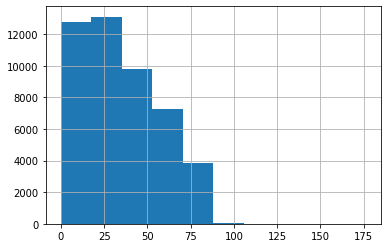

In [30]:
hist=train['Months since last delinquent'].hist()

Como vemos los meses que pasaron desde la ultima vez hubo un delito es la columna con mayor cantidad de datos faltantes. Voy a asumir que los datos faltantes corresponden a personar que no tienen antencedentes penales y les asigno el numero 176.



In [0]:
train['Months since last delinquent'].replace(np.nan,176,inplace=True)

Ahora si ya podemos eliminar las filas que contengan datos faltantes, ya que no estamos periendo gran cantidad


In [0]:
train=train.dropna(axis=0,how='any')

Separamos los datos de las labels

In [0]:
Xtest=train.drop(columns=['Loan ID','Customer ID','Loan Status'])

In [0]:
Ytest=train['Loan Status']

In [0]:
Ytest=Ytest.map({'Fully Paid':1,'Charged Off':2})
Ytest=Ytest.to_numpy()

Ahora es el momento de pasar a variables categoricas y dummy

In [0]:
Xtest['Term']=Xtest['Term'].map({'Short Term':0,'Long Term':1})

In [0]:
Xtest['Years in current job']=Xtest['Years in current job'].map({'< 1 year':0,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10})

In [0]:
Xtest['Home Ownership']=Xtest['Home Ownership'].map({'Home Mortgage':0,'Rent':1,'Own Home':2,'HaveMortgage':3})

In [0]:
Xtest=pd.get_dummies(Xtest,columns=['Purpose'],drop_first=True)

Momento de normalizar.

In [0]:
from sklearn.preprocessing import StandardScaler
Xtest = StandardScaler().fit_transform(Xtest)

Ahora si la red de Kohonen

In [0]:
auxInput=[]

class SOM:
    def __init__(self, dimx, dimy, dimz, eta):
        self.W = (2*np.random.random((dimx,dimy, dimz)) - 1)/10
        self.initGaussian = 9
        self.initEta = eta
        self.gaussian = 0
        self.eta = 0
        self.actualInput = 0
        self.Ys = []
        self.Xs = []
        self.cmap = colors.ListedColormap(['black','gray','Blue','red', 'Green','cyan', 'magenta','yellow','darkorange','lime'])
        self.plot = plt.figure(figsize=(self.W.shape[0],self.W.shape[1]))
        self.Ytest = []
        self.Xtest = []
        
    def train(self, X, Y, epochs, Xtest, Ytest):
        self.Xtest = Xtest
        self.Ytest = Ytest
        self.Ys = Y
        self.Xs = X
        iteracion = 0
        for it in range(epochs):
            self.Xs, self.Ys = self.shuffleArrays(self.Xs, self.Ys)            
            for xi in X:
                self.gaussian = self.gaussianParam(iteracion)
                self.eta = self.etaParam(iteracion)
                closest = self.findClosest(xi)
                self.updateW(xi, closest)
                iteracion += 1
            if((it % 1 == 0) and (self.eta<0.02)):
                print(datetime.datetime.now())
                print("Epoca %s, Eta %s, Gaussian %s" % (it, self.eta, self.gaussian))
                print("Vecindad lejano %s" % (self.neighbor(np.array([0,0]), np.array([6,6]))))
                print("Vecindad cercano %s" % (self.neighbor(np.array([3,3]), np.array([6,6]))))
                print("Vecindad del ganador %s" % (self.neighbor(np.array([5,5]), np.array([6,6]))))
                self.validate(9,it)

    def shuffleArrays(self, arr1, arr2):                  #orden aleatorio en la entrada y salida (manteniendo los pares)
        p = np.random.permutation(len(arr1))
        return arr1[p], arr2[p]

    def diff(self, wi):
        return np.linalg.norm(wi-self.actualInput)
    
    def findClosest(self, input):
        self.actualInput = input
        aux = np.apply_along_axis(self.diff, 2, self.W)
        idx = np.where(aux == np.amin(aux))
        return np.array([idx[0],idx[1]]).reshape(1,2)[0]

    def updateW(self, input, winner): #NO ITERAR
        for f in range(self.W.shape[0]):
            for c in range(self.W.shape[1]):
                neighbor = self.neighbor(np.array([f,c]), winner)
                self.W[f, c] += self.eta * neighbor * (input - self.W[f, c])
        return

    def neighbor(self, neuronIdx, winner):##testear (falta que al ppio cubra toda la grilla)
        return np.exp(-1 * np.linalg.norm(neuronIdx-winner) **2 / (2*self.gaussian**2))

    def gaussianParam(self, it):
        return self.initGaussian * np.exp(-1* it / (10**(6.5)/np.log(self.initGaussian)))

    def etaParam(self, it):
        return self.initEta * np.exp(-1 * it / 10**(6.5))

    def validate(self, clusters, ep):
        Wtest = np.zeros((self.W.shape[0], self.W.shape[1], clusters+1))
        for xtest, ytest in zip(self.Xs, self.Ys):
            closest = self.findClosest(xtest)
            Wtest[closest[0], closest[1],ytest] +=1
        Wplot = np.zeros((self.W.shape[0], self.W.shape[1]))
        for f in range(Wplot.shape[0]):
            for c in range(Wplot.shape[1]):
                Wplot[f,c] = numpy.argmax((Wtest[f,c])) 
        print(Wplot)
        bounds=[0,1,2,3,4,5,6,7,8,9,10]
        norm = colors.BoundaryNorm(bounds, self.cmap.N)
        plt.pcolor(Wplot[::-1],cmap=self.cmap,edgecolors='k', linewidths=3, norm=norm)
        #plt.savefig('%s_som.png' % (ep))
        plt.pause(0.05)
        self.test(Wplot)

    def test(self, clusters):
        ok = 0
        for xtest, ytest in zip(self.Xtest, self.Ytest):
            closest = self.findClosest(xtest)
            if(clusters[closest[0], closest[1]] == ytest):
                ok = ok +1
        print("Total %s, Ok %s, Error %s (%s porc.)" % (self.Xtest.shape[0], ok, self.Xtest.shape[0]-ok, (self.Xtest.shape[0]-ok)*100/self.Xtest.shape[0]))

#####################################################################################

def getData(file, inputCols, outputCols, outputFirst = True):
    results = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) 
        for row in reader: 
            results.append(row)
    results = np.array(results)
    results = pd.DataFrame(results) #paso los datos a un data frame
    if(outputFirst):
        entradas = results.iloc[:,outputCols:outputCols+inputCols] #Separo los datos de entrada
        salidas  = results.iloc[:,0:outputCols] #separo las salidas
    else:
        entradas = results.iloc[:,0:inputCols] #Separo los datos de entrada
        salidas  = results.iloc[:,inputCols:inputCols+outputCols] #separo las salidas
    return entradas, salidas

def splitdata (X,Y,n):
    X1 = pd.DataFrame(X)
    Y1 = pd.DataFrame(Y)
    r = np.random.randint(0,5000)
    Xtep = X1.sample(frac=n,random_state=r)
    Ytep = Y1.sample(frac=n,random_state=r)
    Xtest = X1.drop(Xtep.index)
    Ytest = Y1.drop(Ytep.index)
    Xtep = Xtep.to_numpy()
    Ytep = Ytep.to_numpy()
    Xtest = Xtest.to_numpy()
    Ytest =Ytest.to_numpy()
    return Xtep, Ytep, Xtest, Ytest
  
#X, y = getData("gdrive/My Drive/tp2.csv", 850, 1, True)
##pca = PCA(n_components=3)
##pca.fit(X)
##samples = np.dot(X, pca.components_.T)

#sanger=wpca11787

#samples = np.dot(X, sanger.T)
#print(samples.shape)

#separo datos de test
#Xtrain, Ytrain, Xtest, Ytest = splitdata(samples,y,0.9)



net = SOM(11, 11, Xtest.shape[1], 0.1)
net.train(Xtest, Ytest, 50000, Xtest, Ytest)